In [1]:
import ast
import pandas as pd

import numpy as np

from plotnine import *
import matplotlib.pyplot as plt

from sklearn.manifold import MDS
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import (accuracy_score, 
                             make_scorer, 
                             precision_score, 
                             recall_score, 
                             cohen_kappa_score, 
                             f1_score, 
                             matthews_corrcoef, 
                             log_loss, 
                             plot_confusion_matrix, 
                             roc_auc_score,
                             plot_roc_curve)

import sys
sys.path.append('../')
from utils.cv_helpers import *

In [2]:
with open('../../her2-status_config.json', 'r') as f:
    config = ast.literal_eval(f.read())

In [3]:
cv_scheme = RepeatedStratifiedKFold(n_splits=config['FOLDS'], n_repeats=config['REPEATS'], random_state=config['SEED'])
palette = ["#C9E5D5", "#a7d6bb", "#1cbd9c", "#4FA775", "#2C5D41"]
scoring = {
    'Accuracy': make_scorer(accuracy_score),
    'Precision': make_scorer(precision_score),
    'Recall': make_scorer(recall_score),
    'Kappa': make_scorer(cohen_kappa_score),
    'MCC': make_scorer(matthews_corrcoef),
    'LL': make_scorer(log_loss),
    'F1': make_scorer(f1_score),
    'AUC': make_scorer(roc_auc_score)
}

In [4]:
X = pd.read_csv(config['TRAIN_DATA_FILE']).set_index('sample_id')
y = pd.read_csv(config['Y_TRAIN_FILE']).set_index('sample_id')

X_holdout = pd.read_csv(config['HOLDOUT_DATA_FILE']).set_index('sample_id')
y_holdout = pd.read_csv(config['Y_HOLDOUT_FILE']).set_index('sample_id')

all_X = pd.concat([X, X_holdout])
all_y = pd.concat([X, y_holdout])

high_purity = all_X[all_X['Purity'] >= 0.6].index
low_purity = all_X[all_X['Purity'] < 0.6].index

high_ploidy = all_X[all_X['Ploidy'] >= 3].index
low_ploidy = all_X[all_X['Ploidy'] < 3].index

high_coverage = all_X[all_X['Tumour Average Depth'] >= 49].index
low_coverage = all_X[all_X['Tumour Average Depth'] < 49].index

In [5]:
no_sanger_data = pd.merge(X, y, right_index=True, left_index=True)
no_sanger_data['Class'] = pd.Categorical(no_sanger_data['Class'], categories=[0, 1])

<AxesSubplot:>

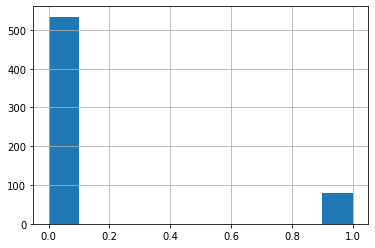

In [6]:
no_sanger_data['Class'].hist()

/home/rstepien/miniconda3/envs/machine_learning/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/home/rstepien/miniconda3/envs/machine_learning/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_histogram : Removed 1 rows containing missing values.


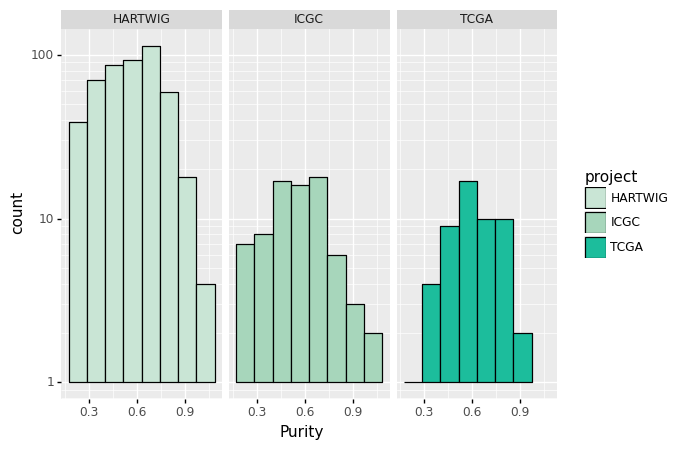

<ggplot: (8760435489365)>

In [7]:
(ggplot(no_sanger_data, aes(x='Purity', fill='project')) + \
     geom_histogram(bins=8, color='black') + \
     facet_wrap('project') + \
     scale_y_log10() + \
     scale_fill_manual(values=palette)
)

/home/rstepien/miniconda3/envs/machine_learning/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
/home/rstepien/miniconda3/envs/machine_learning/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_histogram : Removed 4 rows containing missing values.


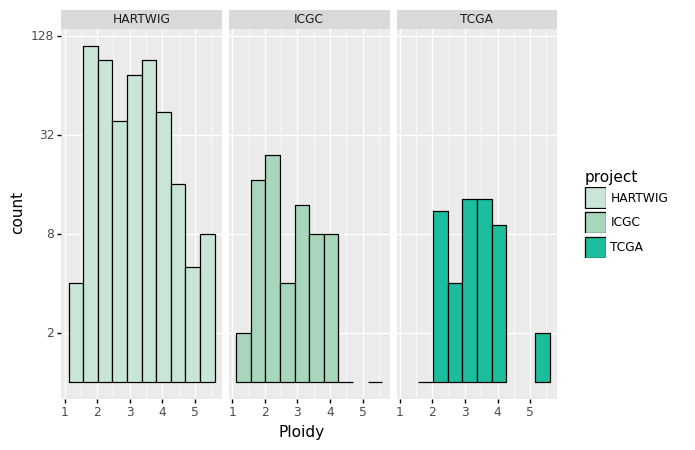

<ggplot: (8760435515133)>

In [8]:
(ggplot(no_sanger_data, aes(x='Ploidy', fill='project')) + \
     geom_histogram(bins=10, color='black') + \
     scale_y_continuous(trans='log2') + \
     facet_wrap('project') + \
     scale_fill_manual(values=palette)
)

/home/rstepien/miniconda3/envs/machine_learning/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
/home/rstepien/miniconda3/envs/machine_learning/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_histogram : Removed 12 rows containing missing values.


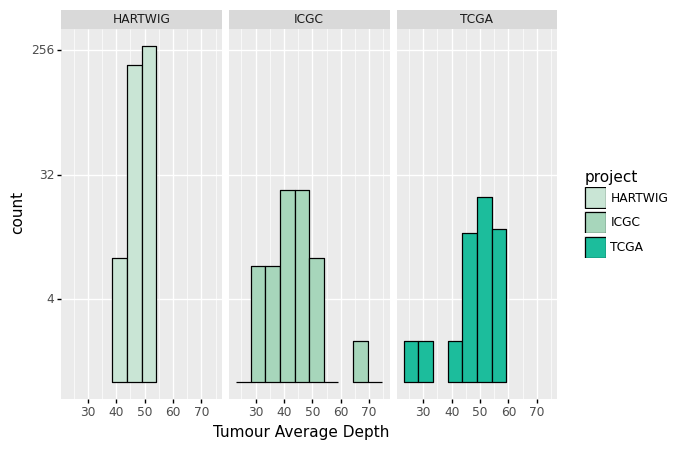

<ggplot: (8760435369647)>

In [9]:
(ggplot(no_sanger_data, aes(x='Tumour Average Depth', fill='project')) + \
     geom_histogram(bins=10, color='black') + \
     scale_y_continuous(trans='log2') + \
     facet_wrap('project') + \
     scale_fill_manual(values=palette)
)

/home/rstepien/miniconda3/envs/machine_learning/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
/home/rstepien/miniconda3/envs/machine_learning/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_histogram : Removed 10 rows containing missing values.


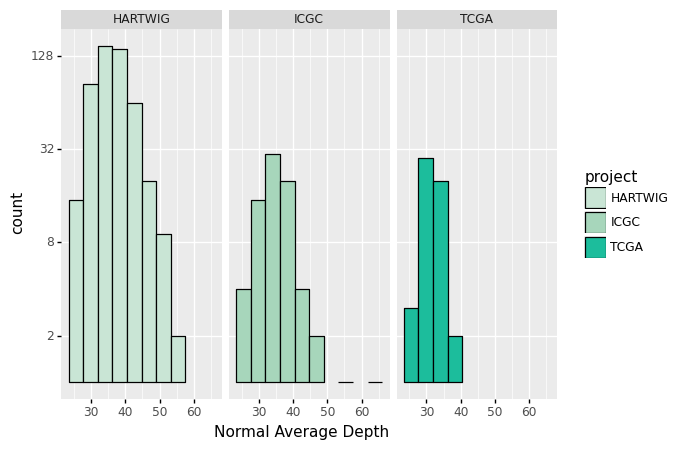

<ggplot: (8760433640418)>

In [10]:
(ggplot(no_sanger_data, aes(x='Normal Average Depth', fill='project')) + \
     geom_histogram(bins=10, color='black') + \
     scale_y_continuous(trans='log2') + \
     facet_wrap('project') + \
     scale_fill_manual(values=palette)
)

In [11]:
X = X.drop(['normal_sample_id', 'Tumour Average Depth', 'Normal Average Depth', 'project'], axis=1)

In [12]:
embedding = MDS(n_components=2, random_state=0)
X_scaled = pd.DataFrame(embedding.fit_transform(X), columns=['Component 1', 'Component 2'])
X_scaled['sample_id'] = X.index
X_scaled = X_scaled.set_index('sample_id')
X_scaled = pd.merge(X_scaled, y, left_index=True, right_index=True)

In [13]:
X_scaled['Component 1'] = X_scaled['Component 1'] + abs(min(X_scaled['Component 1'])) + 1
X_scaled['Component 2'] = X_scaled['Component 2'] + abs(min(X_scaled['Component 2'])) + 1

In [14]:
X_scaled['Class'] = pd.Categorical(X_scaled['Class'], categories=[0, 1])

/home/rstepien/miniconda3/envs/machine_learning/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/rstepien/miniconda3/envs/machine_learning/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../reports/her2-status/pca.png


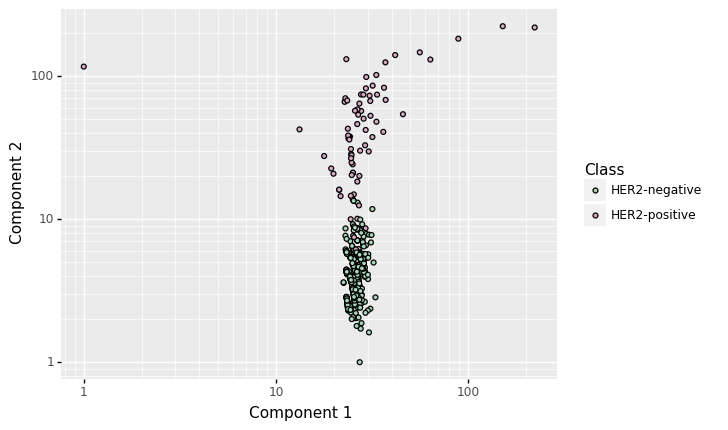

<ggplot: (8760427275978)>

In [18]:
p = (ggplot(X_scaled, aes(x='Component 1', y='Component 2', fill='Class')) + \
    geom_point() +
    scale_y_continuous(trans='log10') +
    scale_x_continuous(trans='log10') +
    scale_fill_manual(("#a7d6bb", "#D6A8C2"), labels=('HER2-negative', 'HER2-positive'))
)

p.save('../../reports/her2-status/pca.png')
p

In [16]:
best_params_dt = DecisionTreeClassifier(ccp_alpha=0.01, class_weight='balanced', max_depth=1, min_samples_leaf=1, min_samples_split=2).fit(X, y)

In [22]:
high_purity_df = estimator_cv_evaluation(X=X[X.index.isin(high_purity)], 
                                  y=y[y.index.isin(high_purity)], 
                                  estimator_name='High purity',
                                  estimator_object=best_params_dt,
                                  cv_scheme=cv_scheme,
                                  scoring=scoring
                                  )

low_purity_df = estimator_cv_evaluation(X=X[X.index.isin(low_purity)], 
                                  y=y[y.index.isin(low_purity)], 
                                  estimator_name='Low purity',
                                  estimator_object=best_params_dt,
                                  cv_scheme=cv_scheme,
                                  scoring=scoring
                                  )

high_ploidy_df = estimator_cv_evaluation(X=X[X.index.isin(high_ploidy)], 
                                  y=y[y.index.isin(high_ploidy)], 
                                  estimator_name='High ploidy',
                                  estimator_object=best_params_dt,
                                  cv_scheme=cv_scheme,
                                  scoring=scoring
                                  )

low_ploidy_df = estimator_cv_evaluation(X=X[X.index.isin(low_ploidy)], 
                                  y=y[y.index.isin(low_ploidy)], 
                                  estimator_name='Low ploidy',
                                  estimator_object=best_params_dt,
                                  cv_scheme=cv_scheme,
                                  scoring=scoring
                                  )

high_coverage_df = estimator_cv_evaluation(X=X[X.index.isin(high_coverage)], 
                                  y=y[y.index.isin(high_coverage)], 
                                  estimator_name='High coverage',
                                  estimator_object=best_params_dt,
                                  cv_scheme=cv_scheme,
                                  scoring=scoring
                                  )

low_coverage_df = estimator_cv_evaluation(X=X[X.index.isin(low_coverage)], 
                                  y=y[y.index.isin(low_coverage)], 
                                  estimator_name='Low coverage',
                                  estimator_object=best_params_dt,
                                  cv_scheme=cv_scheme,
                                  scoring=scoring
                                  )

comparison_df = pd.concat([high_purity_df, low_purity_df, high_ploidy_df, low_ploidy_df, high_coverage_df, low_coverage_df])


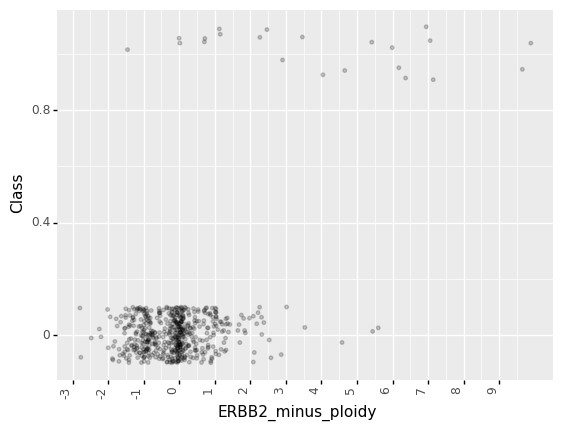

<ggplot: (8760433320177)>

In [23]:
import numpy as np
all = pd.merge(X, y, right_index=True, left_index=True)
subset = all[all['ERBB2_minus_ploidy'] < 10]

labels = range(round(min(subset['ERBB2_minus_ploidy'])), round(max(subset['ERBB2_minus_ploidy'])), 1)

(ggplot(subset, aes(y='Class', x='ERBB2_minus_ploidy')) +\
    geom_point(size=1, alpha=0.2, position = position_jitter(width = 0, height = 0.1)) +\
    theme(axis_text_x=element_text(rotation=90, hjust=1)) + \
    scale_x_continuous(labels=labels, breaks=labels)
)